<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets

    
- Determine water body polygons


- Build the Digital Elevation Model



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True.</font> <br>
<font size=5 color='blue'> If you are running on your own computer, set the variable yes_colab = False </font>


In [2]:
yes_colab = True


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [3]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')
if yes_colab:
  where_to_mount = '/content/drive/'
  from google.colab import drive
  drive.mount(where_to_mount, force_remount=True)
  mounted_drive = Path(where_to_mount) / 'MyDrive' 
  sys.path.append(str(mounted_drive / 'installations'))
  path_ancillary = mounted_drive / 'ancillary'
  Path(mounted_drive / 'installations').mkdir(parents=True, exist_ok=True)

else:
  mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))
  path_ancillary = mounted_drive / 'BAM/ancillary'

print('Your working directory is %s' %(mounted_drive))



Mounted at /content/drive/
Your working directory is /content/drive/MyDrive


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [4]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive / 'BAM'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive / 'BAM')
    #!git fsck --full
    # !git add -A 
    !git stash   
    !git pull
    # !rm -rf {mounted_drive/'BAM'}

  else:
    print('## Pulling the git repository with files for the tutorial\n')
    !git clone https://github.com/achri19/BAM.git


## Updating the local git repository 

Saved working directory and index state WIP on main: 42f28f2 updated
Already up to date.


In [35]:
if yes_colab:
  print('\n## Installing the Python packages needed for these tutorials\n')
  try:
    import geopandas as gpd
  except:
    !/bin/bash $mounted_drive/BAM/notebooks/install_packages_colab_debug.sh



## Installing the Python packages needed for these tutorials

(1) Install pip packages to /content/drive/MyDrive/installations
nose mpi4py triangle dill Pmw pymetis mpi4py pyproj gdal geemap cmocean geopandas fiona pygeos rasterio rasterstats scikit-fmm rtree pyTMD Orinoco
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
  Using cached Rtree-1.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached shapely-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Using cached numpy-1.24.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached pandas-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached mpi4py-3.1.4-cp39-cp39-linux_x86_64.whl
  Using cached triangle-20220202-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
  Using cached dill-0.3.6-py3-none-any.whl

In [5]:
path_ancillary = mounted_drive / 'BAM/ancillary'
path_code = mounted_drive / 'BAM/scripts/'
path_templates = mounted_drive /  'BAM/templates/'
path_configs = mounted_drive / 'BAM/configs/'
sys.path.insert(1,str(path_code))
print(path_code)
print(path_ancillary)

path_examples = mounted_drive / 'BAM/examples'
Path(path_examples).mkdir(parents=True, exist_ok=True)

/content/drive/MyDrive/BAM/scripts
/content/drive/MyDrive/BAM/ancillary


In [6]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
from scipy import *


/content/drive/MyDrive/installations/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-6-cb0d4ecab280>:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import

In [7]:
try:
  import pyTMD
except:
  !pip install pytmd

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)


<font size=6> Step #1c: Unzip example files in Komo.zip <font> 




In [8]:
import zipfile
with zipfile.ZipFile("komo_starter.zip", 'r') as zip_ref:
    zip_ref.extractall(path_examples)
    

<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


AOI should match the name of the folder where files will be saved

In [9]:
AOI = 'komo'

Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/BAM/examples/komo
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
###################

<font size='6' > Step #3: Configuration Parameters </font>


In [10]:
try:
    parameters = pd.read_csv(folders[6] / ('config_%s.csv' %(AOI)))
except:    
    parameters = pd.DataFrame()
    parameters['AOI'] = [AOI]
    parameters['RiverOceanBoundary'] = '1260'
    parameters['Discharge'] = '426'

    #Method parameters:
    parameters['LandcoverMethod'] = 'WorldCover'
    parameters['LandElevMethod'] = 'GLO30'
    parameters['OceanElevMethod'] = 'GEBCO'
    parameters['LowerRiverElevMethod'] = 'plane'
    parameters['UpperRiverElevMethod'] = 'wdpower'
    parameters['WetlandElevMethod'] = 'constant_0.5'
    parameters['LakeElevMethod'] = 'constant_1'
    parameters['ManningLUT'] = 'default'
    parameters['WetlandClass'] = '90'

    #Coefficients for determining bathymetry:
    parameters['WD_POWERA_upper'] = '0.0606'
    parameters['WD_POWERB_upper'] = '0.7732'

    #Max thresholds:
    parameters['MaxOceanDepth'] = '-300'
    parameters['MaxNearshoreDepth'] = '-300'
    parameters['MaxRiverDepth'] = '-300'
    parameters['MaxRiverWidth'] = '756'



If you didn't run the Download notebook, the following cells will download ancillary data you need for this notebook. However, it could take a while and will download 8-10GB on your Google Drive.

In [11]:
import urllib.request
if os.path.isfile(path_ancillary / 'geoids' / 'egm08_25.gtx')==False:

  url = 'https://download.osgeo.org/proj/vdatum/egm08_25/egm08_25.gtx'
  filename = path_ancillary / 'geoids' / 'egm08_25.gtx'
  urllib.request.urlretrieve(url, filename)


if os.path.isfile(path_ancillary / 'gebco' / 'gebco_all.vrt')==False:
  url = 'https://www.bodc.ac.uk/data/open_download/gebco/gebco_2022_sub_ice_topo/geotiff/'
  filename = path_ancillary / 'gebco' / 'gebco.zip'
  urllib.request.urlretrieve(url, filename)

  with zipfile.ZipFile(path_ancillary / 'gebco' / 'gebco.zip', 'r') as zip_ref:
      zip_ref.extractall(path_ancillary / 'gebco' )

  gebco_files = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(path_ancillary / 'gebco')
                for f in fnmatch.filter(files,'*gebco_2022*.tif')]
  print(gebco_files)

  with open(path_ancillary / 'gebco' / 'gebco_files.txt', 'w') as f:
    for item in gebco_files:
      f.write("%s\n" % item)
  ! gdalbuildvrt -input_file_list {path_ancillary}/gebco/gebco_files.txt {path_ancillary}/gebco/gebco_all.vrt
  !rm {path_ancillary}/'gebco'/'gebco.zip'

if os.path.isfile(path_ancillary / 'gmw' / 'gmw_v3_2016_vec.shp')==False:
  url = 'https://zenodo.org/record/6894273/files/gmw_v3_2016_vec.zip?download=1'
  filename = path_ancillary / 'gmw' / 'gmw_v3_2016_vec.zip'
  urllib.request.urlretrieve(url, filename)

  with zipfile.ZipFile(path_ancillary / 'gmw' / 'gmw_v3_2016_vec.zip', 'r') as zip_ref:
      zip_ref.extractall(path_ancillary / 'gmw')

!rm {path_ancillary}/'gmw'/'gmw_v3_2016_vec.zip'


In [17]:

ref_10m = rasterio.open('%s_GEBCO_%s.tif' %(folders[8] / AOI,res))

ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)





##############################################################################################
##############################[Step 1b][GetExtentParameters]##################################
##############################################################################################

##################### AOI extent is set by: komo_input.shp
The input shapefile is not in the correction projection (EPSG 4326), reprojecting to EPSG 4326

[Step 2][Setup_AOI_Files][Determine EPSG code and UTM zone] .......

##################### ANUGA Models must be in UTM
##################### UTM Zone: 32n
##################### EPSG: 32232 

[Step 2][Setup_AOI_Files][Extending AOI by 1000m] .......


[Step 2][Setup_AOI_Files][Setting up AOI extent] .......

##################### AOI bounds are : 501790, -2260, 610150, 64700
##################### Approximate area of AOI extent is 7256.0 km^2

[Step 2][Setup_AOI_Files][Downloading GEBCO Dataset as reference for projection, resolution, etc] .......


[S

Text(0.5, 1.0, 'GEBCO Bathymetry resampled to 10m resolution')

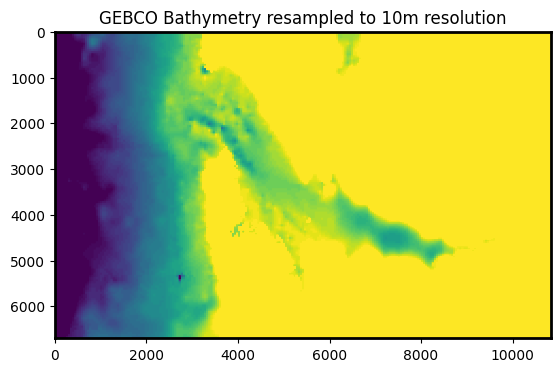

In [18]:
plt.imshow(ref_10m.read(1),vmin=-50,vmax=0)
plt.title('GEBCO Bathymetry resampled to 10m resolution')

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [ ]:
parameters = pd.read_csv(folders[2] / ('%s_Configuration.csv' %(AOI)))
print(parameters.iloc[0] )

<font size='6' > Step #4: Download datasets </font>
<br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [ ]:
ref = setup_AOI_files(your_path,
                    AOI,
                    folders,
                    res,
                    parameters)


<font size='5' color = 'red' > The EPSG coordinate reference system must be is in UTM </font>


In [ ]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]


In [ ]:
#ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))
glo30 = rasterio.open(folders[8] / ('%s_GLO30_topo_%s.tif' %(AOI,res)))
landcover = rasterio.open(folders[8] / ('%s_WorldCover_%s.tif' %(AOI,res)))


fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(10,10))
ax1.imshow(glo30.read(1),vmin=0,vmax=50,cmap = 'viridis')
ax1.set_title('Tandem-X GLO30 Topography at 30m resolution')

ax2.imshow(landcover.read(1),cmap='jet_r')
ax2.set_title('WorldCover Landcover Map')


In [ ]:
model_domain = gpd.read_file(folders[7] / ('%s_modeldomain.shp' %(AOI)))

fig,ax = plt.subplots(figsize=(10,10))
model_domain.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 2,ax=ax,label = 'model domain') #Use your second dataframe

plt.legend()

<font size='6' > Step #4: Clean the water mask </font> <br>
Clean, filter, smooth the water mask you made in the previous notebook </font>



In [ ]:
#ref_10m = rasterio.open('%s/%s_GEBCO_10.tif' %(folders[8],AOI))
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,
                               False, 
                               os.path.isfile('%s_watermask_%s.tif' %(folders[8]/AOI,res)))
how_much_opening = 3
if os.path.isfile('%s_watermask_%s.tif' %(folders[8]/AOI,30)) == False:
    more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)


In [ ]:
print(watermaskname)
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8]/ ("%s_watermask_10.tif " %(AOI)),folders[8] / ("%s_watermask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8] / ("%s_landmask_10.tif" %(AOI)),folders[8] / ("%s_landmask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))


In [ ]:
watermask = rasterio.open(folders[8] / ('%s_watermask_%s.tif' %(AOI,res))).read(1)

fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(15,15))
ax1.imshow(watermask,'gray')

ax2.imshow(watermask,'gray')
ax2.axis([1500,2000, 2000,1500])

<font size='6' > Step #5: Make polygons of each land cover type <br> </font>
Ocean, lake, river, land


In [ ]:
make_polygons(AOI,
            folders,
            parameters,
            ref,
            watermaskname,
            path_templates,
            os.path.isfile('%s_lands_%s.tif' %(folders[8]/AOI,res)))


In [ ]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    i=i+1
plt.legend()


<font size='6' > Step #6: Using Orinoco, get distance and width of the river networks</font>


In [ ]:
segment_width = 150
pixel_step = int(round(segment_width/res))
try:
  distance = gdal.Open('%s_distance_%s.tif' %(folders[8] / AOI,res)).ReadAsArray()
  widths = gdal.Open('%s_widths_%sx%s.tif' %(folders[8] / AOI,res,pixel_step)).ReadAsArray()
except:
  distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,False)


<font size='6' > Step #7: Make the Digital Elevation Model </font>


In [ ]:
elevation,elev_name = make_model_foundation(mounted_drive,
                                                parameters,
                                                AOI,
                                                folders,
                                                ref,
                                                distance,
                                                widths,
                                                watermask,pixel_step,mounted_drive)


<font size=5 color='green'> We will use the elevation file in later notebooks. </font>

In [ ]:
print(elev_name)


<font size='6' > Step #6: Clean up temporary files </font> <br>


In [ ]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done building DEM and other ancillary files. Move on to the next notebook 3_GetBoundaries.ipynb </font>
